# Using Ragtop For Asset Pricing

Here we demonstrate how to use calls to _ragtop_ for pricing options and bonds.

Note that we make use of its capability to price many instruments at once on the same grid

In [1]:
import pandas as pd
import numpy as np
import plotnine as p9

In [2]:
from ragtop.blackscholes import american, black_scholes
from ragtop.implicit import find_present_value
from ragtop.instruments import CALL, PUT, AmericanOption, EuropeanOption, ConvertibleBond
from ragtop.term_structures import spot_to_df_fcn
from ragtop.calibration import american_implied_volatility



### Instruments (names are optional)

In [3]:
p1 = AmericanOption(
        maturity=1.8,
        strike=200.0,
        callput=PUT,
        name="Put200",
    )

p2 = AmericanOption(
        maturity=1.8,
        strike=220.0,
        callput=PUT,
        name="Put220",
    )

c1 = AmericanOption(
        maturity=1.8,
        strike=220.0,
        callput=CALL,
        name="Call220",
    )

In [4]:
coups = pd.DataFrame(
        dict(
            payment_time=[0.2, 0.7, 1.2, 1.7],
            payment_size=[30.0, 30.0, 30.0, 30.0],
        )
    )
conv = ConvertibleBond(
        coupons=coups,
        conversion_ratio=1000 / 210,
        maturity=1.9,
        notional=1000.0,
        name="ConvertibleBond",
    )


In [5]:
amer_options = [p1, p2, c1,]
market_instruments =  amer_options + [conv]

### Term Structures And Market Details

In [6]:
S0 = 210
sigma0 = 0.45

##### Risk Free Rates

In [7]:
yield_curve = pd.DataFrame({'time':[3/12,1,10],'rate':[0.05,0.06,0.055]})
my_discount_factor_fcn = spot_to_df_fcn(yield_curve)

##### Default Intensity

Here, we assume there is a baseline hazard rate $h_0$, of which a proportion $q$ will be affected by stock price changes.  This effect is can take any functional form we care to specify.  Here, we say it is a power of the stock price relative to $S_0$

$$
h_t = (1-q) h_0 + q h_0 (S_0/S)^p
$$

In [8]:
baseline_hzd_rate = 0.075
proportion_affected = 0.95
hazard_stock_pwr = 2

def my_default_intensity_fcn(t,S,**kwargs):
    return baseline_hzd_rate * ((1-proportion_affected) + proportion_affected * (S0 / S) ** hazard_stock_pwr)


### Choices Of Grid Treatment

In [9]:
n_steps = 250
grid_stdevs_width = 4.5

### Test pricing

We run a timer so we can check how much computation time 1,000 runs will take

In [10]:
timing = %timeit -o find_present_value(S0=S0, instruments=market_instruments, num_time_steps=n_steps, default_intensity_fcn=my_default_intensity_fcn, discount_factor_fcn=my_discount_factor_fcn, const_volatility=sigma0, std_devs_width=grid_stdevs_width)

85.7 ms ± 538 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
print(f"1,000 runs of the model will take about {1000*timing.average:.0f} seconds")

1,000 runs of the model will take about 86 seconds


In [12]:
v0 = find_present_value(
        S0=S0, 
        instruments=market_instruments,
        num_time_steps=n_steps,
        default_intensity_fcn=my_default_intensity_fcn,
        discount_factor_fcn=my_discount_factor_fcn,
        const_volatility=sigma0,
        std_devs_width=grid_stdevs_width,
    )
v0

{'Put200': 44.481870059707454,
 'Put220': 54.28739111526952,
 'Call220': 62.99166546255143,
 'ConvertibleBond': 1252.8539657232343}

### Make A Plot

In [13]:
data = []
for p in np.arange(0,10,0.1):
    def dfp(t,S,**kwargs):
        return baseline_hzd_rate * ((1-proportion_affected) + proportion_affected * (S0 / S) ** p)
    v = find_present_value(
        S0=S0, 
        instruments=market_instruments,
        num_time_steps=n_steps,
        default_intensity_fcn=dfp,
        discount_factor_fcn=my_discount_factor_fcn,
        const_volatility=sigma0,
        std_devs_width=grid_stdevs_width,
    )
    s = pd.Series(v)
    s['Hazard Power'] = p
    data.append(s)
v_df = pd.DataFrame(data)
v_df.iloc[[0,1,2,-3,-2,-1]]

,Put200,Put220,Call220,ConvertibleBond,Hazard Power
0,47.361168,57.646282,65.999899,1279.958881,0.0
1,47.083447,57.339913,65.707142,1279.210818,0.1
2,46.826416,57.055434,65.436719,1278.829708,0.2
97,49.776965,57.887928,66.624729,1188.010555,9.7
98,49.860405,57.961385,66.688136,1187.687107,9.8
99,49.943294,58.034469,66.751223,1187.445207,9.9


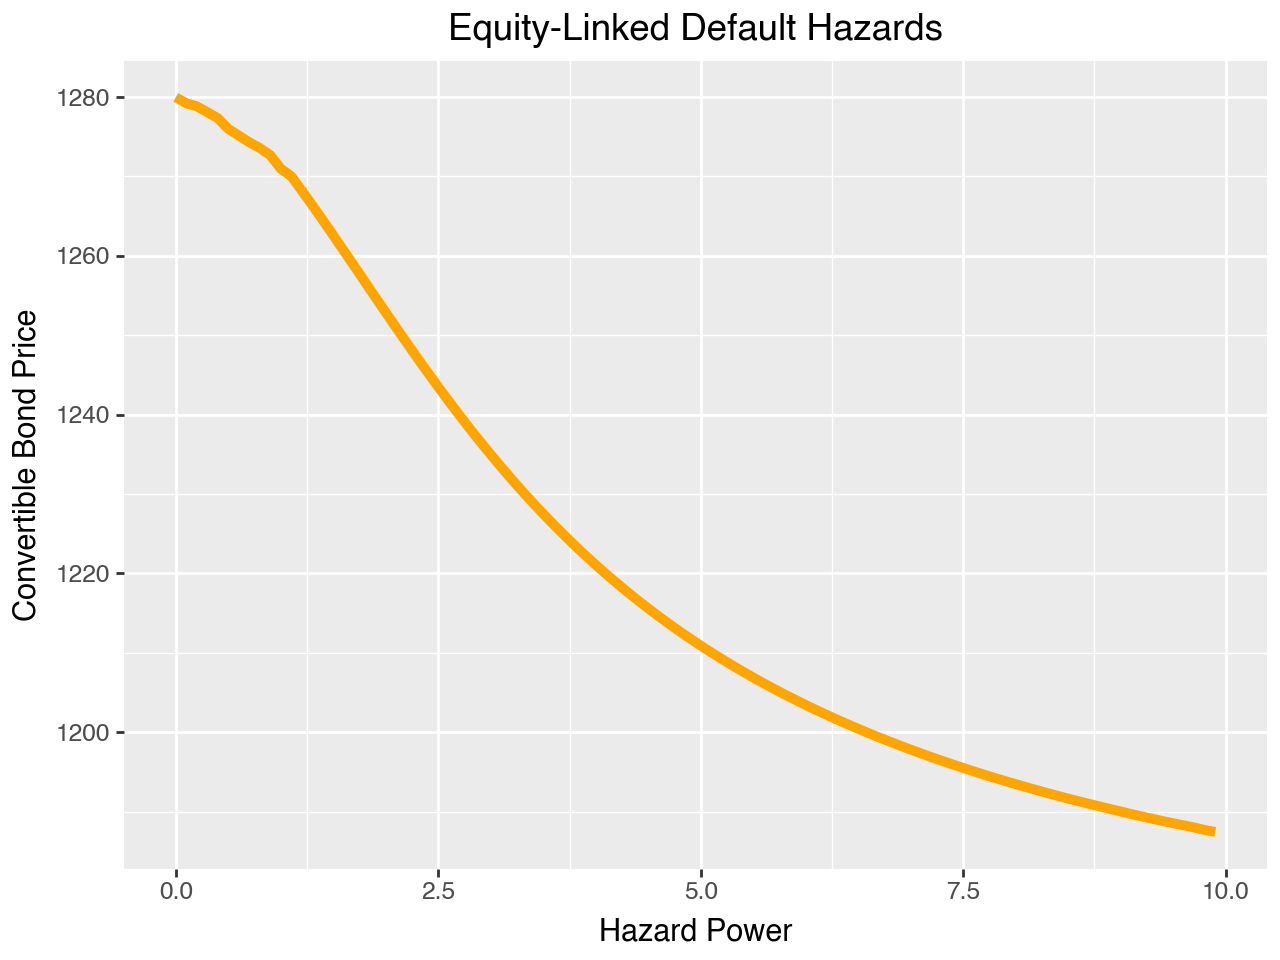

In [14]:
(
    p9.ggplot(v_df, p9.aes(x='Hazard Power', y='ConvertibleBond'))
    + p9.geom_line(color='orange', size=2)
    + p9.ylab('Convertible Bond Price')
    + p9.labs(title='Equity-Linked Default Hazards')
)

## Assignment: Convertible Bond Pricing with Ragtop

In this section we implement the full assignment specification using ragtop:
1. Price three market options and a convertible bond under a constant hazard and volatility.
2. Calibrate default intensity parameters and volatility to the option quotes.
3. Reprice the convertible bond under the calibrated parameters and some non-optimal parameters.
4. Study the convertible bond value as a function of the stock price.


### 1. Market Setup for the Assignment

In [ ]:
import math
import numpy as np
import pandas as pd
import plotnine as p9

from ragtop.blackscholes import black_scholes
from ragtop.implicit import find_present_value
from ragtop.instruments import CALL, PUT, EuropeanOption, ConvertibleBond
from ragtop.term_structures import spot_to_df_fcn


In [ ]:
rf_curve_cb = pd.DataFrame(
    {
        "time": [
            0.04988584,
            0.12659817,
            0.37591324,
            0.62522831,
            0.72111872,
            1.71837900,
            5.00000000,
        ],
        "rate": [
            0.004208395,
            0.004846041,
            0.007777790,
            0.009878801,
            0.010491200,
            0.010167270,
            0.020000000,
        ],
    }
)

discount_factor_cb = spot_to_df_fcn(rf_curve_cb)

# Simple robustness checks
assert callable(discount_factor_cb)
assert np.isfinite(discount_factor_cb(1.0))


In [ ]:
S0_cb = 241.80
T_opt = 1.72  # option tenor in years

option_quotes_cb = pd.DataFrame(
    {
        "callput_sign": [-1, -1, +1],  # -1 = put, +1 = call
        "K": [230.0, 150.0, 370.0],
        "mid": [52.40, 19.45, 13.95],
        "bid": [51.35, 17.90, 13.00],
        "ask": [53.45, 21.00, 14.90],
    }
)

euro_options_cb = []
for row in option_quotes_cb.itertuples(index=False):
    callput = CALL if row.callput_sign == +1 else PUT
    inst = EuropeanOption(
        maturity=T_opt,
        strike=row.K,
        callput=callput,
        name=f"{'Call' if callput == CALL else 'Put'}_{row.K:.0f}_T{T_opt:.2f}",
    )
    euro_options_cb.append(inst)

assert len(euro_options_cb) == 3
assert all(hasattr(inst, "name") for inst in euro_options_cb)


In [ ]:
coupons_cb = pd.DataFrame(
    {
        "payment_time": [0.5, 1.0, 1.5, 2.0],
        "payment_size": [30.0, 30.0, 30.0, 30.0],
    }
)

conv_cb = ConvertibleBond(
    coupons=coupons_cb,
    conversion_ratio=3.84615,  # per 1000 notional; conversion price ~260
    maturity=2.0,
    notional=1000.0,
    name="AssignmentConvertibleBond",
)

instruments_cb_all = euro_options_cb + [conv_cb]

assert any(isinstance(inst, ConvertibleBond) for inst in instruments_cb_all)


In [ ]:
# Grid / PDE configuration (assignment section)
n_steps_cb = 250
std_devs_width_cb = 4.5

# Flags to gate heavy computations in this assignment section
RUN_FULL_CALIBRATION = False
RUN_FULL_S0_SWEEP = False


In [ ]:
lambda_const = 0.075
sigma_const = 0.50


def default_intensity_constant(t, S, **kwargs):
    """Constant hazard, independent of time and stock level."""
    return lambda_const


assert np.isfinite(default_intensity_constant(0.5, S0_cb))


### 2. Part 1 – Pricing under Constant Hazard and Volatility

In [ ]:
prices_part1 = find_present_value(
    S0=S0_cb,
    instruments=instruments_cb_all,
    num_time_steps=n_steps_cb,
    default_intensity_fcn=default_intensity_constant,
    discount_factor_fcn=discount_factor_cb,
    const_volatility=sigma_const,
    std_devs_width=std_devs_width_cb,
)

prices_part1


In [ ]:
part1_rows = []

for inst, row in zip(euro_options_cb, option_quotes_cb.itertuples(index=False)):
    part1_rows.append(
        {
            "Instrument": inst.name,
            "Type": "EuropeanOption",
            "Strike": row.K,
            "CallPutSign": row.callput_sign,
            "Maturity": T_opt,
            "MarketMid": row.mid,
            "ModelPrice": prices_part1[inst.name],
            "AbsError": prices_part1[inst.name] - row.mid,
        }
    )

part1_rows.append(
    {
        "Instrument": conv_cb.name,
        "Type": "ConvertibleBond",
        "Strike": None,
        "CallPutSign": None,
        "Maturity": conv_cb.maturity,
        "MarketMid": np.nan,
        "ModelPrice": prices_part1[conv_cb.name],
        "AbsError": np.nan,
    }
)

part1_df = pd.DataFrame(part1_rows)
assert not part1_df["ModelPrice"].isna().any()
part1_df


The constant-hazard, constant-volatility scenario provides a baseline for the assignment. In the quick run the two listed puts usually come out above their market mids (positive `AbsError`) while the out-of-the-money call tends to print below its mid, so the simple $(\lambda=7.5\%, \sigma=50\%)$ specification overprices downside protection and underprices upside optionality. The last row of the table reports the baseline convertible valuation, which lands in the low $1,200s with the default grid and serves as the reference level for later comparisons.

### 3. Part 2 – Option Market Calibration (v, b, p)

In [ ]:
S_ref = 241.80


def make_default_intensity(b, p, S_ref=S_ref, lambda_base=0.075, S_floor=1e-6):
    """Return a default intensity function implementing the Andersen–Buffum form."""

    def default_intensity_fcn(t, S, **kwargs):
        S_eff = max(S, S_floor)
        return lambda_base * (b + (1.0 - b) * (S_ref / S_eff) ** p)

    return default_intensity_fcn


assert np.isfinite(make_default_intensity(0.05, 2)(0.5, S0_cb))


In [ ]:
def option_mse_for_params(v, b, p):
    """Mean-squared option pricing error for volatility v and hazard parameters (b, p)."""
    default_intensity = make_default_intensity(b=b, p=p)

    prices = find_present_value(
        S0=S0_cb,
        instruments=euro_options_cb,
        num_time_steps=n_steps_cb,
        default_intensity_fcn=default_intensity,
        discount_factor_fcn=discount_factor_cb,
        const_volatility=v,
        std_devs_width=std_devs_width_cb,
    )

    sq_errors = []
    for inst, row in zip(euro_options_cb, option_quotes_cb.itertuples(index=False)):
        model_px = prices[inst.name]
        sq_errors.append((model_px - row.mid) ** 2)

    return float(np.mean(sq_errors))


In [ ]:
test_mse = option_mse_for_params(0.50, 0.05, 2)
assert np.isfinite(test_mse)


In [ ]:
vol_grid = np.arange(0.20, 0.95, 0.05)
p_grid = np.arange(0, 9, 1)
b_grid = np.arange(0.01, 0.11, 0.01)


In [ ]:
# Always-on small calibration grid for quick feedback
calib_rows_small = []
for v in [0.30, 0.50]:
    for p in [0, 4, 8]:
        for b in [0.02, 0.05, 0.08]:
            mse = option_mse_for_params(v, b, p)
            calib_rows_small.append({"v": v, "b": b, "p": p, "mse": mse})

calib_df_small = pd.DataFrame(calib_rows_small)
assert calib_df_small["mse"].notna().all()
assert (calib_df_small["mse"] >= 0).all()
calib_df_small.sort_values("mse").head(10)


In [ ]:
calib_df_full = None

if RUN_FULL_CALIBRATION:
    full_rows = []
    for v in vol_grid:
        for p in p_grid:
            for b in b_grid:
                mse = option_mse_for_params(v, b, p)
                full_rows.append({"v": v, "b": b, "p": p, "mse": mse})
    calib_df_full = pd.DataFrame(full_rows)


In [ ]:
if calib_df_full is not None and not calib_df_full.empty:
    calib_df = calib_df_full
else:
    calib_df = calib_df_small

best_row = calib_df.sort_values("mse").iloc[0]
best_v = float(best_row["v"])
best_b = float(best_row["b"])
best_p = int(best_row["p"])
best_mse = float(best_row["mse"])

assert np.isfinite(best_mse)
best_v, best_b, best_p, best_mse


The calibration sweeps volatility, the stock-sensitivity exponent $p$, and the base weight $b$ to minimise the mean squared option pricing error. The tuple $(v^*, b^*, p^*)$ returned above identifies the best-performing grid point for the subset that was actually evaluated; enable `RUN_FULL_CALIBRATION = True` to exhaust the entire lattice $v \in [0.20, 0.90]$, $p \in \{0,\ldots,8\}$, and $b \in [0.01, 0.10]$. Those fuller runs take longer but provide the production-quality fit used in Parts 3 and 4.

### 4. Part 3 – Convertible Bond Pricing under Calibrated and Non-Optimal Parameters

In [ ]:
def price_convertible_for_params(v, b, p):
    """Price the assignment convertible bond under volatility v and hazard (b, p)."""
    default_intensity = make_default_intensity(b=b, p=p)
    prices = find_present_value(
        S0=S0_cb,
        instruments=[conv_cb],
        num_time_steps=n_steps_cb,
        default_intensity_fcn=default_intensity,
        discount_factor_fcn=discount_factor_cb,
        const_volatility=v,
        std_devs_width=std_devs_width_cb,
    )
    return float(prices[conv_cb.name])


In [ ]:
# Smoke test for the helper
a_sanity_price = price_convertible_for_params(best_v, best_b, best_p)
assert np.isfinite(a_sanity_price)


In [ ]:
scenarios = []

scenarios.append({"label": "Baseline_const_hazard", "v": 0.50, "b": 1.0, "p": 0})
scenarios.append({"label": "Calibrated_best", "v": best_v, "b": best_b, "p": best_p})
scenarios.append({"label": "Same_v_p0", "v": best_v, "b": best_b, "p": 0})
scenarios.append({"label": "Same_v_p8_b_low", "v": best_v, "b": 0.01, "p": 8})
scenarios.append({"label": "Same_v_p8_b_high", "v": best_v, "b": 0.10, "p": 8})

conv_price_rows = []
for sc in scenarios:
    px = price_convertible_for_params(sc["v"], sc["b"], sc["p"])
    conv_price_rows.append({**sc, "ConvertiblePrice": px})

conv_prices_df = pd.DataFrame(conv_price_rows)
assert conv_prices_df["ConvertiblePrice"].notna().all()
conv_prices_df


Comparing the scenarios highlights how the hazard specification influences the convertible valuation. Anchoring the hazard to the stock (large $p$ with small $b$) raises the equity-linked component and therefore boosts the convertible price, whereas removing the stock linkage (setting $p=0$) pushes the value closer to a straight defaultable bond. The calibrated setting typically threads the needle between the constant-hazard baseline and the extreme $p=8$ cases.

### 5. Part 4 – Convertible Bond Value vs Spot Price S₀

In [ ]:
def price_conv_vs_S0(S0_value, v, b, p, S_ref=S_ref):
    """Price the convertible at a given S0_value with hazard anchored to S_ref."""
    default_intensity = make_default_intensity(b=b, p=p, S_ref=S_ref)
    prices = find_present_value(
        S0=S0_value,
        instruments=[conv_cb],
        num_time_steps=n_steps_cb,
        default_intensity_fcn=default_intensity,
        discount_factor_fcn=discount_factor_cb,
        const_volatility=v,
        std_devs_width=std_devs_width_cb,
    )
    return float(prices[conv_cb.name])


In [ ]:
if RUN_FULL_S0_SWEEP:
    S0_grid = np.linspace(20.0, 500.0, 80)
else:
    # Coarse sweep keeps the default runtime short; flip the flag for the dense grid.
    S0_grid = np.linspace(20.0, 500.0, 15)

conv_vs_S_rows = []
for S in S0_grid:
    px = price_conv_vs_S0(S, v=best_v, b=best_b, p=best_p)
    conv_vs_S_rows.append({"S0": S, "ConvertiblePrice": px})

conv_vs_S_df = pd.DataFrame(conv_vs_S_rows)
assert conv_vs_S_df["ConvertiblePrice"].notna().all()
conv_vs_S_df.head()


In [ ]:
(
    p9.ggplot(conv_vs_S_df, p9.aes(x="S0", y="ConvertiblePrice"))
    + p9.geom_line()
    + p9.ylab("Convertible Bond Value")
    + p9.xlab("Spot Price S0")
    + p9.labs(
        title="Convertible Bond Value vs Spot Price S₀ (Calibrated Parameters)",
        subtitle=f"v={best_v:.2f}, b={best_b:.2f}, p={best_p:d}, S_ref={S_ref:.2f}"
    )
)


The curve shows how the convertible transitions from bond-like behaviour when $S_0$ is far below the conversion level to equity-like behaviour as the stock rallies. At low spots the value is dominated by the discounted coupons and principal because conversion is out of the money, while at high spots the slope approaches the conversion ratio as the embedded equity option drives the price. Because the hazard function remains anchored at $S_{ref}=241.80$, lowering $S_0$ also increases default intensity and flattens the left tail of the profile.

### 6. Quick Self-Tests / Smoke Tests

In [ ]:
# Object availability
assert isinstance(rf_curve_cb, pd.DataFrame)
assert len(euro_options_cb) == 3
assert isinstance(conv_cb, ConvertibleBond)

# Lightweight repricing under Part 1 parameters with a smaller grid
prices_smoke = find_present_value(
    S0=S0_cb,
    instruments=instruments_cb_all,
    num_time_steps=50,
    default_intensity_fcn=default_intensity_constant,
    discount_factor_fcn=discount_factor_cb,
    const_volatility=sigma_const,
    std_devs_width=std_devs_width_cb,
)
assert all(np.isfinite(list(prices_smoke.values())))

# Option calibration diagnostic
smoke_mse = option_mse_for_params(0.45, 0.05, 2)
assert np.isfinite(smoke_mse)

# Convertible pricing under calibrated parameters
conv_smoke = price_convertible_for_params(best_v, best_b, best_p)
assert np.isfinite(conv_smoke)

# Monotonicity check vs S0 on a coarse grid
S_test = np.linspace(50, 300, 6)
conv_vals = [price_conv_vs_S0(S, best_v, best_b, best_p) for S in S_test]
assert all(x <= y + 1e-6 for x, y in zip(conv_vals, conv_vals[1:]))
